In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import re
import pandas as pd
import numpy as np

import pandas
import os

from reconchess import GameHistory
import matplotlib.pyplot as plt
from tqdm import tqdm

### Find approximate quantiles

In [4]:
data_path = "../game_logs/ranked_games"

wins = []
losses = []

for batch in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, batch)):
        continue
    for game_id in tqdm(os.listdir(os.path.join(data_path, batch))):
        try:
            game = GameHistory.from_file(os.path.join(data_path, batch, game_id, f"game_{game_id}.log"))
            has_won = (game.get_white_player_name() == "Zubat") == game.get_winner_color()
            game_log = os.path.join(data_path, batch, game_id, f"move_scores_{game_id}.csv")
            df = pd.read_csv(game_log)
            mx = df.groupby("move_number").max()
            if has_won:
                wins.append(mx["analytical"].to_list())
            else:
                losses.append(mx["analytical"].to_list())
        except:
            pass

100%|██████████| 2/2 [00:00<?, ?it/s]


In [8]:
len(wins), len(losses)

(667, 226)

In [9]:
res = np.array([x for win in wins for x in win] + [x for loss in losses for x in loss] * 3)
len(res)

44597

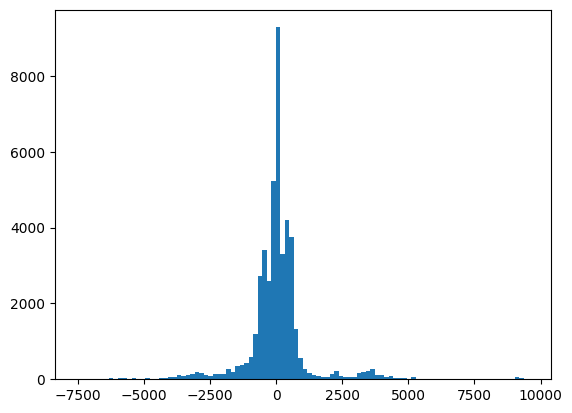

In [10]:
plt.hist(res, bins=100)
plt.show()

In [11]:
len(res[res >= 0]), len(res[res < 0])

(24299, 20298)

In [12]:
pd.qcut(res[res >= 0], 2), pd.qcut(res[res < 0], 2)

([(0.0359, 365.34], (0.0359, 365.34], (0.0359, 365.34], (0.0359, 365.34], (0.0359, 365.34], ..., (365.34, 9538.0], (365.34, 9538.0], (0.0359, 365.34], (0.0359, 365.34], (0.0359, 365.34]]
 Length: 24299
 Categories (2, interval[float64, right]): [(0.0359, 365.34] < (365.34, 9538.0]],
 [(-426.252, -0.0204], (-426.252, -0.0204], (-426.252, -0.0204], (-426.252, -0.0204], (-426.252, -0.0204], ..., (-426.252, -0.0204], (-426.252, -0.0204], (-426.252, -0.0204], (-426.252, -0.0204], (-7519.336, -426.252]]
 Length: 20298
 Categories (2, interval[float64, right]): [(-7519.336, -426.252] < (-426.252, -0.0204]])

In [13]:
len(res[res < -400]), len(res[(res < 0) & (res >= -400)]), len(res[(res < 400) & (res >= 0)]), len(res[res >= 400])

(10679, 9619, 12963, 11336)

Ranges will be (-inf, -400), (-400, 0), (0, 400), (400, inf)

### Calculating

In [18]:
categories = [0, 20, 40, 60, 80, 100, 120]
result_thresholds = [-50, 50]
risky_move_threshold = 50

In [19]:
results = pd.DataFrame(
    {"category": [
        f"({categories[i]}, {categories[i+1]})"
        for i in range(len(categories) - 1)
    ] + [f'({categories[-1]}, inf)'], 
     "positive": [0 for _ in range(len(categories))], "neutral": [0 for _ in range(len(categories))], "negative": [0 for _ in range(len(categories))]})
results

,category,positive,neutral,negative
0,"(0, 20)",0,0,0
1,"(20, 40)",0,0,0
2,"(40, 60)",0,0,0
3,"(60, 80)",0,0,0
4,"(80, 100)",0,0,0
5,"(100, 120)",0,0,0
6,"(120, inf)",0,0,0


In [20]:
data_path = "../game_logs/unranked_games"
for batch in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, batch)):
        continue
    for bot in os.listdir(os.path.join(data_path, batch)):
        for game_id in tqdm(os.listdir(os.path.join(data_path, batch, bot))):
            try:
                path = os.path.join(data_path, batch, bot, game_id)
                game = GameHistory.from_file(os.path.join(path, f"game_{game_id}.log"))
                game_log = os.path.join(path, f"move_scores_{game_id}.csv")
                df = pd.read_csv(game_log)
                
                gr_df = df.groupby("move_number")
                risky_moves = np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] < risky_move_threshold)[0] + 1
                risky_moves = np.append(risky_moves, np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] >= risky_move_threshold)[0] + 1)
                
                true_scores = gr_df.max()["true_score"]
                for move in risky_moves:
                    category = np.digitize(move, categories) - 1
                    if move < len(gr_df):
                        result = np.digitize(true_scores[move] - true_scores[move + 1], result_thresholds)
                        results.iloc[category, result+1] += 1
                    else:
                        result = 2 * (game.get_white_player_name() == "Zubat") == game.get_winner_color()
                        results.iloc[category, result+1] += 1
            except:
                pass

100%|██████████| 50/50 [00:00<00:00, 57.42it/s]


In [30]:
results = results.rename(columns={'category': 'move number'})
results

,move number,positive,neutral,negative
0,"(0, 20)",9776,45030,11329
1,"(20, 40)",9874,33434,11595
2,"(40, 60)",3939,15632,4001
3,"(60, 80)",1431,6782,1177
4,"(80, 100)",571,3530,457
5,"(100, 120)",285,1634,209
6,"(120, inf)",170,916,125


In [31]:
results2 = results.copy()
results2["positive"] = results["positive"] / (results["positive"] + results["neutral"] + results["negative"])
results2["neutral"] = results["neutral"] / (results["positive"] + results["neutral"] + results["negative"])
results2["negative"] = results["negative"] / (results["positive"] + results["neutral"] + results["negative"])
results2

,move number,positive,neutral,negative
0,"(0, 20)",0.147819,0.680880,0.171301
1,"(20, 40)",0.179844,0.608965,0.211191
2,"(40, 60)",0.167105,0.663160,0.169735
3,"(60, 80)",0.152396,0.722258,0.125346
4,"(80, 100)",0.125274,0.774462,0.100263
5,"(100, 120)",0.133929,0.767857,0.098214
6,"(120, inf)",0.140380,0.756400,0.103220


In [32]:
results.to_csv("tables/risk_results_time.csv", index=False)
results2.to_csv("tables/risk_results_time_percentage.csv", index=False)

In [37]:
print(results2.to_latex(index=False, float_format='{:.2%}'.format))

\begin{tabular}{lrrr}
\toprule
move number &  positive &  neutral &  negative \\
\midrule
    (0, 20) &    14.78\% &   68.09\% &    17.13\% \\
   (20, 40) &    17.98\% &   60.90\% &    21.12\% \\
   (40, 60) &    16.71\% &   66.32\% &    16.97\% \\
   (60, 80) &    15.24\% &   72.23\% &    12.53\% \\
  (80, 100) &    12.53\% &   77.45\% &    10.03\% \\
 (100, 120) &    13.39\% &   76.79\% &     9.82\% \\
 (120, inf) &    14.04\% &   75.64\% &    10.32\% \\
\bottomrule
\end{tabular}


### Graph

In [10]:
data_path = "../game_logs/unranked_games"

results = []
for batch in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, batch)):
        continue
    for bot in os.listdir(os.path.join(data_path, batch)):
        for game_id in tqdm(os.listdir(os.path.join(data_path, batch, bot))):
            try:
                path = os.path.join(data_path, batch, bot, game_id)
                game = GameHistory.from_file(os.path.join(path, f"game_{game_id}.log"))
                game_log = os.path.join(path, f"move_scores_{game_id}.csv")
                df = pd.read_csv(game_log)
                
                gr_df = df.groupby("move_number")
                risky_moves = np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] > risky_move_threshold)[0] + 1
                
                true_scores = gr_df.max()["true_score"]
                for move in risky_moves:
                    if move < len(gr_df):
                        if abs(true_scores[move+1]) == 8000:
                            results.append((move, true_scores[move+1]))
                        else:
                            results.append((move, true_scores[move + 1] - true_scores[move]))
                    else:
                        result = 2 * (game.get_white_player_name() == "Zubat") == game.get_winner_color() - 1
                        results.append((move, result * 8000))
            except:
                pass
            
results

100%|██████████| 50/50 [00:00<00:00, 110.98it/s]


[(29, 8000),
 (26, -5),
 (27, -898),
 (52, -8000),
 (36, -8000),
 (25, -39),
 (21, 27),
 (31, 8000),
 (24, -172),
 (22, 5),
 (37, -14),
 (8, -29),
 (20, 78),
 (21, 7),
 (71, 0),
 (19, 32),
 (26, -256),
 (23, -100),
 (22, 8000),
 (30, -5),
 (16, -197),
 (13, -30),
 (20, -52),
 (82, 46),
 (21, -8000),
 (38, -686),
 (19, -8),
 (73, 8000),
 (101, 8000),
 (103, -4033),
 (38, -13),
 (37, -46),
 (68, -75),
 (19, -76),
 (29, -8000),
 (28, -95),
 (33, -13),
 (10, -86),
 (29, 8000),
 (42, -10),
 (43, -222),
 (36, -28),
 (101, -4),
 (104, 1),
 (21, 10),
 (15, -8000),
 (14, -100),
 (59, 2605),
 (60, 8000),
 (22, -101),
 (30, -393),
 (2, -79),
 (6, -26),
 (36, -8000),
 (33, 113),
 (34, 57),
 (37, -7180),
 (35, -8000),
 (7, -49),
 (32, -12),
 (37, 5),
 (21, -34),
 (22, -69),
 (34, -65),
 (35, -109),
 (28, -157),
 (35, -8000),
 (31, -18),
 (10, -967),
 (12, 173),
 (17, -178),
 (25, 279),
 (16, -459),
 (58, -59),
 (67, -11),
 (5, -21),
 (26, 8000),
 (9, -57),
 (20, -40),
 (40, -49),
 (27, -64),
 (50, 

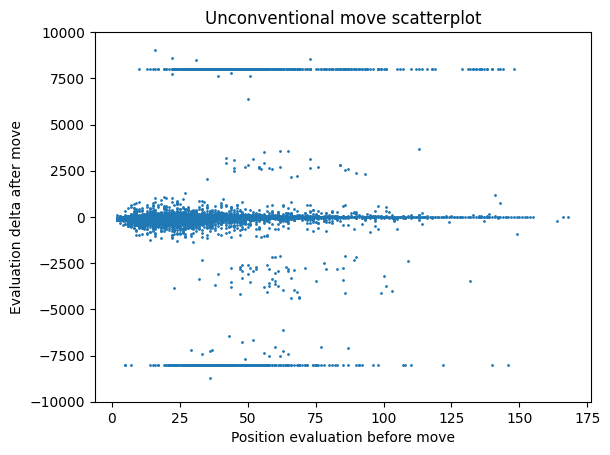

In [11]:
plt.scatter([r[0] for r in results], [r[1] for r in results], s=1)
# plt.xlim(0, 200)
plt.ylim(-10000, 10000)

plt.title("Unconventional move scatterplot")
plt.xlabel("Position evaluation before move")
plt.ylabel("Evaluation delta after move")

plt.savefig('imgs/unconventional_move_scatter.png')

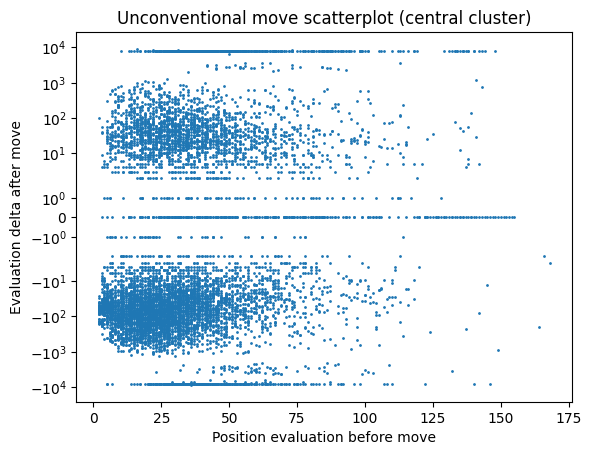

In [12]:
plt.scatter([r[0] for r in results], [r[1] for r in results], s=1)
# plt.xlim(-1300, 1300)
# plt.ylim(-1000, 1000)
plt.yscale('symlog')

plt.title("Unconventional move scatterplot (central cluster)")
plt.xlabel("Position evaluation before move")
plt.ylabel("Evaluation delta after move")

plt.savefig('imgs/unconventional_move_scatter2.png')

## Individual game

In [56]:
risky_move_threshold = 50
dir = "../game_logs/unranked_games/u4r4/StrangeFish2"
game_id = "1701716767"

game = GameHistory.from_file(os.path.join(dir, game_id, f"game_{game_id}.log"))
game_log = os.path.join(dir, game_id, f"move_scores_{game_id}.csv")
df = pd.read_csv(game_log)

gr_df = df.groupby("move_number")
risky_moves = np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] > risky_move_threshold)[0] + 1
risky_moves = np.append(risky_moves, np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] >= risky_move_threshold)[0] + 1)
risky_moves



# analytical_scores = gr_df.max()["analytical"]
# for move in risky_moves:
#     category = np.digitize(analytical_scores[move], categories)
#     if move < len(gr_df):
#         result = np.digitize(analytical_scores[move] - analytical_scores[move+1], result_thresholds)
#         results.iloc[3-category, result+1] += 1
#     else:
#         result = 2 * (game.get_white_player_name() == "Zubat") == game.get_winner_color()
#         results.iloc[3-category, result+1] += 1

array([15, 18, 22, 15, 18, 22], dtype=int64)

In [57]:
df[df["move_number"] == 15]

,move_number,move,score,analytical,uncertainty,gamble
507,15,e4e5,31.864500,-115.603182,0.404987,528.258349
508,15,e1e3,21.137266,-11.577182,0.102272,439.754000
509,15,e1f2,12.785331,-66.594091,0.243324,452.458076
510,15,b3d4,11.251639,-24.526045,0.151416,272.575000
511,15,e1g3,-36.801903,-115.868091,0.299893,327.296000
512,15,c1e3,-41.353170,-78.139545,0.161344,256.000000
513,15,e1d2,-74.031595,-94.757727,0.326396,-73.000000
514,15,h2h3,-75.985076,-139.006045,0.243324,318.000000
515,15,d3d4,-90.270673,-182.021364,0.326266,362.428571
516,15,a2a4,-124.958131,-214.957727,0.280663,441.335294


In [58]:
risky_move_threshold = 100
dir = "../game_logs/unranked_games/u4r4/StrangeFish2"
for i, game_id in enumerate(os.listdir(dir)):
    try:
        game = GameHistory.from_file(os.path.join(dir, game_id, f"game_{game_id}.log"))
        game_log = os.path.join(dir, game_id, f"move_scores_{game_id}.csv")
        df = pd.read_csv(game_log)
        
        gr_df = df.groupby("move_number")
        risky_moves = np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] > risky_move_threshold)[0] + 1
        risky_moves = np.append(risky_moves, np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] >= risky_move_threshold)[0] + 1)
        
        true_scores = gr_df.max()["analytical"]
        for move in risky_moves:
            category = np.digitize(true_scores[move], categories)
            if move < len(gr_df):
                if true_scores[move + 1] - true_scores[move] < 200:
                    print(f"{i} {game_id}   {move}   {true_scores[move + 1] - true_scores[move]}")
            else:
                print(f"{i} {game_id}   {move}   {'win' if (game.get_white_player_name() == 'Zubat') == game.get_winner_color() else 'loss'}")            
    except:
        pass

0 1701710908   11   21.994724523016856
0 1701710908   22   -446.93768000000006
0 1701710908   11   21.994724523016856
0 1701710908   22   -446.93768000000006
1 1701712629   9   -165.84553333333338
1 1701712629   10   90.9823541666666
1 1701712629   12   79.98775993827167
1 1701712629   16   -136.25531192614807
1 1701712629   24   -57.7018750000002
1 1701712629   30   171.13770245189346
1 1701712629   33   -737.8664466666667
1 1701712629   92   -3651.9625000000005
1 1701712629   9   -165.84553333333338
1 1701712629   10   90.9823541666666
1 1701712629   12   79.98775993827167
1 1701712629   16   -136.25531192614807
1 1701712629   24   -57.7018750000002
1 1701712629   30   171.13770245189346
1 1701712629   33   -737.8664466666667
1 1701712629   92   -3651.9625000000005
2 1701715296   24   -190.7957890909089
2 1701715296   24   -190.7957890909089
4 1701717758   13   24.74791071288679
4 1701717758   43   23.715754773462322
4 1701717758   13   24.74791071288679
4 1701717758   43   23.715754

In [28]:
df = pd.read_csv('tables/risk_results_percentage.csv', index_col=0)
df

,category,positive,neutral,negative
0,"(400, inf)",0.173192,0.656825,0.169983
1,"(0, 400)",0.169668,0.662088,0.168243
2,"(-400, 0)",0.144138,0.692994,0.162868
3,"(-inf, -400)",0.155507,0.628706,0.215787


In [35]:
print(df.to_latex(index=False, float_format='{:.2%}'.format))

\begin{tabular}{lrrr}
\toprule
    category &  positive &  neutral &  negative \\
\midrule
  (400, inf) &    17.32\% &   65.68\% &    17.00\% \\
    (0, 400) &    16.97\% &   66.21\% &    16.82\% \\
   (-400, 0) &    14.41\% &   69.30\% &    16.29\% \\
(-inf, -400) &    15.55\% &   62.87\% &    21.58\% \\
\bottomrule
\end{tabular}
